In [1]:
# TensorFlow and tf.keras

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils



# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
data = np.load('/mnt/data/ml/Constituent4vecDataTest.npz')
#evnum = data['jetconstEvnum']
pt = data['jetconstPt']
eta = data['jetconstEta']
phi = data['jetconstPhi']
labels = data['labels']
tau21 = data['tau21']
chMult = data['chMult']

pt = pt.reshape(336227, 20)
eta = eta.reshape(336227, 20)
phi = phi.reshape(336227, 20)
labels = labels[::20]

fourvec = np.stack((pt,eta,phi), axis = -1)

#ensure same number of signal vs. background and even split of z events
qcd_vec = fourvec[np.where(labels[:,0] == 1)]
qcd_tau = tau21[np.where(labels[:,0] == 1)]
qcd_mult = chMult[np.where(labels[:,0] == 1)]

if len(qcd_vec) % 3 != 0:
    qcd_vec = qcd_vec[:len(qcd_vec)-(len(qcd_vec) % 3)]
    qcd_tau = qcd_tau[:len(qcd_vec)-(len(qcd_vec) % 3)]
    qcd_mult = qcd_mult[:len(qcd_vec)-(len(qcd_vec) % 3)]
    
z1_vec = fourvec[np.where(labels[:,1] == 1)]
z1_vec = z1_vec[:int(len(qcd_vec)/3)]
z1_tau = tau21[np.where(labels[:,1] == 1)]
z1_tau = z1_tau[:int(len(qcd_vec)/3)]
z1_mult = chMult[np.where(labels[:,1] == 1)]
z1_mult = z1_mult[:int(len(qcd_vec)/3)]

z2_vec = fourvec[np.where(labels[:,2] == 1)]
z2_vec = z2_vec[:int(len(qcd_vec)/3)]
z2_tau = tau21[np.where(labels[:,2] == 1)]
z2_tau = z2_tau[:int(len(qcd_vec)/3)]
z2_mult = chMult[np.where(labels[:,2] == 1)]
z2_mult = z1_mult[:int(len(qcd_vec)/3)]

z3_vec = fourvec[np.where(labels[:,3] == 1)]
z3_vec = z3_vec[:int(len(qcd_vec)/3)]
z3_tau = tau21[np.where(labels[:,3] == 1)]
z3_tau = z3_tau[:int(len(qcd_vec)/3)]
z3_mult = chMult[np.where(labels[:,3] == 1)]
z3_mult = z1_mult[:int(len(qcd_vec)/3)]

qcd_lab = np.zeros([len(qcd_vec), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_vec), 2])
z_lab[:,1] = 1

fourvec = np.vstack((qcd_vec, z1_vec, z2_vec, z3_vec))
taus = np.hstack((qcd_tau, z1_tau, z2_tau, z3_tau))
mults = np.hstack((qcd_mult, z1_mult, z2_mult, z3_mult))
labels = np.vstack((qcd_lab, z_lab))
print(len(labels), len(fourvec))

#split data into testing/training/validation
n_data = len(fourvec)
testvec = fourvec[::4]
testlabels = labels[::4]
testtaus = taus[::4]
testmults = mults[::4]

mask_vec = np.ones(fourvec.shape,dtype=bool)
mask_vec[::4] = 0
mask_vec[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
mask_tau = np.ones(taus.shape,dtype=bool)
mask_tau[::4] = 0
mask_tau[1::8] = 0
mask_mult = np.ones(mults.shape,dtype=bool)
mask_mult[::4] = 0
mask_mult[1::8] = 0

valvec = fourvec[1::8]
vallabels = labels[1::8]
valtaus = taus[1::8]
valmults = mults[1::8]

trainvec = fourvec[mask_vec].reshape((n_data-len(testvec)-len(valvec)),20,3)
trainlabels = labels[mask_lab].reshape((n_data-len(testvec)-len(valvec)), 2)
traintaus = taus[mask_tau].reshape((n_data-len(testvec)-len(valvec)), 1)
trainmults = mults[mask_mult].reshape((n_data-len(testvec)-len(valvec)), 1)

99240 99240


In [3]:
best_model = keras.models.load_model('model/CNN1D_v3.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
import innvestigate
import innvestigate.utils as iutils

## General Analysis

In [5]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(best_model)
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model_wo_softmax)

analysis = lrp_analyzer.analyze([testvec[::8],testtaus[::8],testmults[::8]])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/opt/conda/lib/python3.7/site-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.recurrent.GRU object at 0x7f455598f1d0>, <keras.layers.recurrent.GRU object at 0x7f455598f710>, <keras.layers.recurrent.GRU object at 0x7f455598fa20>]
  warnings.warn(tmp_message)


In [6]:
pt_analysis = analysis[0][:,:,0].flatten()
eta_analysis = analysis[0][:,:,1].flatten()
phi_analysis = analysis[0][:,:,2].flatten()
tau_analysis = analysis[1].flatten()
mult_analysis = analysis[2].flatten()

w_pt,  edges_pt = np.histogram(testvec[::8][:,:,0].flatten(), weights = pt_analysis, bins = 32)
w_eta,  edges_eta = np.histogram(testvec[::8][:,:,1].flatten(), weights = eta_analysis, bins = 32)
w_phi,   edges_phi = np.histogram(testvec[::8][:,:,2].flatten(), weights = phi_analysis, bins = 32)
w_tau,  edges_tau = np.histogram(testtaus[::8], weights = tau_analysis, bins = 32)
w_mult,  edges_mult = np.histogram(testmults[::8], weights = mult_analysis, bins = 32)

edges = np.concatenate((edges_pt, edges_eta, edges_phi, edges_tau, edges_mult), axis=0)
edges = edges.reshape(5,33)

half_bin = (edges[:,1]-edges[:,0])/2
half_bin = half_bin.reshape(5,1)
x = edges[:,0:-1]+half_bin

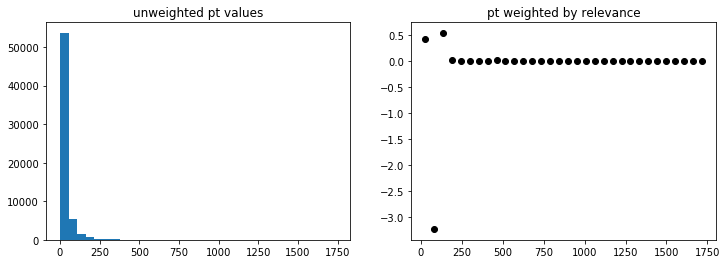

In [7]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(testvec[::8][:,:,0].flatten(), bins = 32)
plt.title("unweighted pt values")
plt.subplot(1,2,2)
plt.scatter(x[0], w_pt, c = '0', label = 'weighted by pt rel')
plt.title("pt weighted by relevance")
plt.show()

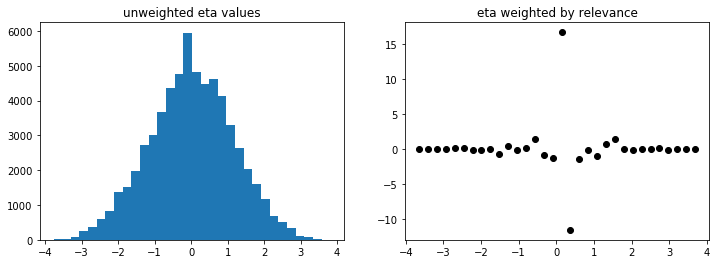

In [8]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(testvec[::8][:,:,1].flatten(), bins = 32)
plt.title("unweighted eta values")
plt.subplot(1,2,2)
plt.scatter(x[1], w_eta, c = '0', label = 'weighted by eta rel')
plt.title("eta weighted by relevance")
plt.show()

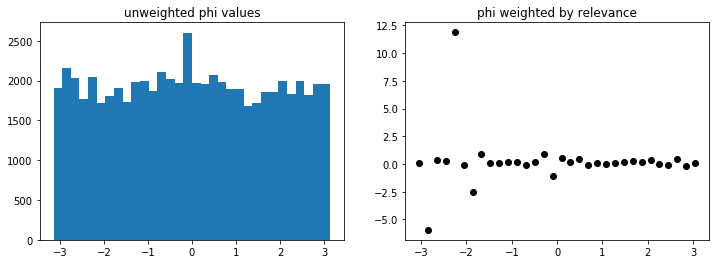

In [9]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(testvec[::8][:,:,2].flatten(), bins = 32)
plt.title("unweighted phi values")
plt.subplot(1,2,2)
plt.scatter(x[2], w_phi, c = '0', label = 'weighted by phi rel')
plt.title("phi weighted by relevance")
plt.show()

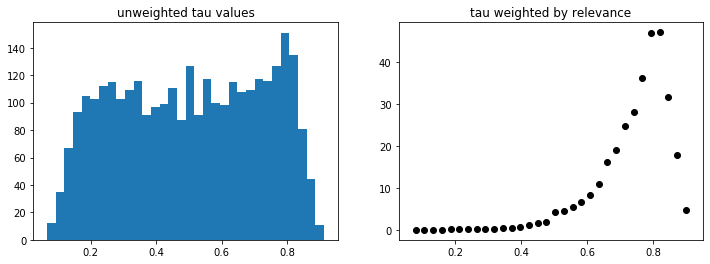

In [10]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(testtaus[::8], bins = 32)
plt.title("unweighted tau values")
plt.subplot(1,2,2)
plt.scatter(x[3], w_tau, c = '0', label = 'weighted by tau rel')
plt.title("tau weighted by relevance")
plt.show()

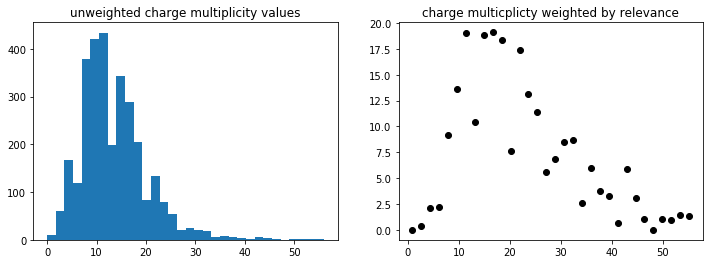

In [11]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(testmults[::8], bins = 32)
plt.title("unweighted charge multiplicity values")
plt.subplot(1,2,2)
plt.scatter(x[4], w_mult, c = '0', label = 'weighted by mult rel')
plt.title("charge multicplicty weighted by relevance")
plt.show()

## Split analysis

### QCD

In [12]:
analysis_qcd = lrp_analyzer.analyze([qcd_vec[::4],qcd_tau[::4],qcd_mult[::4]])

In [13]:
pt_analysis_qcd = analysis_qcd[0][:,:,0].flatten()
eta_analysis_qcd = analysis_qcd[0][:,:,1].flatten()
phi_analysis_qcd = analysis_qcd[0][:,:,2].flatten()
tau_analysis_qcd = analysis_qcd[1].flatten()
mult_analysis_qcd = analysis_qcd[2].flatten()

w_pt_qcd,  edges_pt_qcd = np.histogram(qcd_vec[::4][:,:,0].flatten(), weights = pt_analysis_qcd, bins = 32)
w_eta_qcd,  edges_eta_qcd = np.histogram(qcd_vec[::4][:,:,1].flatten(), weights = eta_analysis_qcd, bins = 32)
w_phi_qcd,   edges_phi_qcd = np.histogram(qcd_vec[::4][:,:,2].flatten(), weights = phi_analysis_qcd, bins = 32)
w_tau_qcd,  edges_tau_qcd = np.histogram(qcd_tau[::4], weights = tau_analysis_qcd, bins = 32)
w_mult_qcd,  edges_mult_qcd = np.histogram(qcd_mult[::4], weights = mult_analysis_qcd, bins = 32)

edges_qcd = np.concatenate((edges_pt_qcd, edges_eta_qcd, edges_phi_qcd, edges_tau_qcd, edges_mult_qcd), axis=0)
edges_qcd = edges_qcd.reshape(5,33)

half_bin_qcd = (edges_qcd[:,1]-edges_qcd[:,0])/2
half_bin_qcd = half_bin_qcd.reshape(5,1)
x_qcd = edges_qcd[:,0:-1]+half_bin_qcd

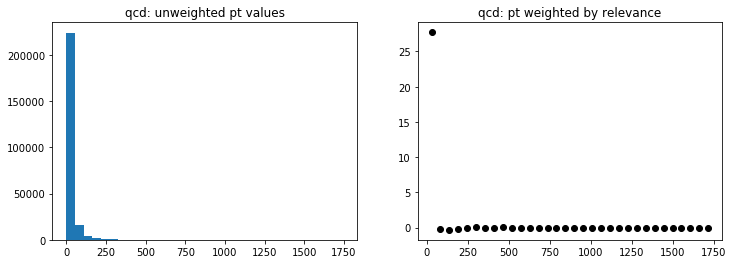

In [14]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(qcd_vec[::4][:,:,0].flatten(), bins = 32)
plt.title("qcd: unweighted pt values")
plt.subplot(1,2,2)
plt.scatter(x_qcd[0], w_pt_qcd, c = '0', label = 'weighted by pt rel')
plt.title("qcd: pt weighted by relevance")
plt.show()

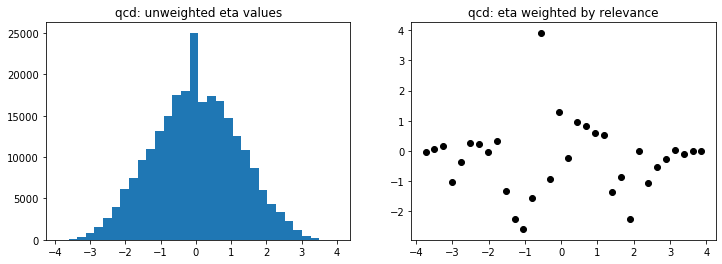

In [15]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(qcd_vec[::4][:,:,1].flatten(), bins = 32)
plt.title("qcd: unweighted eta values")
plt.subplot(1,2,2)
plt.scatter(x_qcd[1], w_eta_qcd, c = '0', label = 'weighted by eta rel')
plt.title("qcd: eta weighted by relevance")
plt.show()

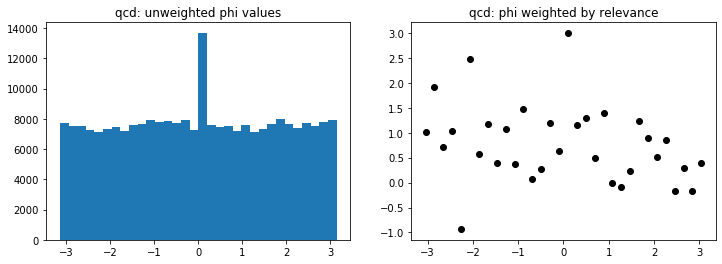

In [16]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(qcd_vec[::4][:,:,2].flatten(), bins = 32)
plt.title("qcd: unweighted phi values")
plt.subplot(1,2,2)
plt.scatter(x_qcd[2], w_phi_qcd, c = '0', label = 'weighted by phi rel')
plt.title("qcd: phi weighted by relevance")
plt.show()

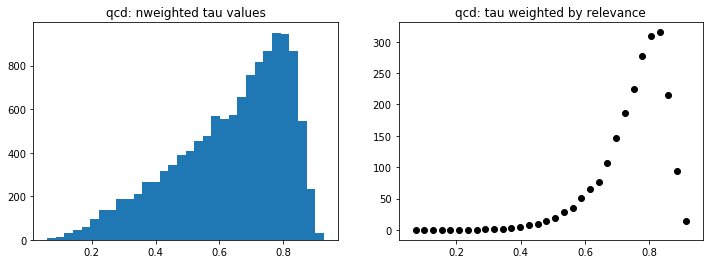

In [17]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(qcd_tau[::4], bins = 32)
plt.title("qcd: nweighted tau values")
plt.subplot(1,2,2)
plt.scatter(x_qcd[3], w_tau_qcd, c = '0', label = 'weighted by tau rel')
plt.title("qcd: tau weighted by relevance")
plt.show()

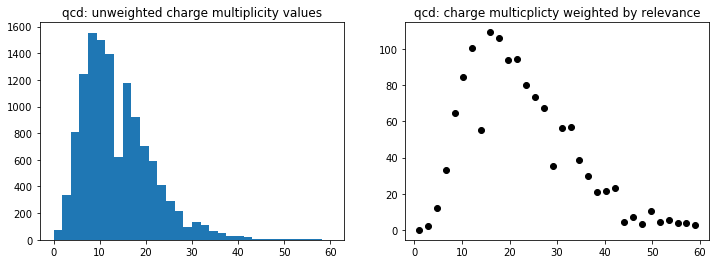

In [18]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(qcd_mult[::4], bins = 32)
plt.title("qcd: unweighted charge multiplicity values")
plt.subplot(1,2,2)
plt.scatter(x_qcd[4], w_mult_qcd, c = '0', label = 'weighted by mult rel')
plt.title("qcd: charge multicplicty weighted by relevance")
plt.show()

### Z

In [21]:
zvec =  np.vstack(( z1_vec, z2_vec, z3_vec))
ztau = np.hstack(( z1_tau, z2_tau, z3_tau))
zmult = np.hstack(( z1_mult, z2_mult, z3_mult))

In [22]:
analysis_z = lrp_analyzer.analyze([zvec[::4],ztaus[::4],zmults[::4]])

In [23]:
pt_analysis_z = analysis_z[0][:,:,0].flatten()
eta_analysis_z = analysis_z[0][:,:,1].flatten()
phi_analysis_z = analysis_z[0][:,:,2].flatten()
tau_analysis_z = analysis_z[1].flatten()
mult_analysis_z = analysis_z[2].flatten()

w_pt_z,  edges_pt_z = np.histogram(zvec[::4][:,:,0].flatten(), weights = pt_analysis_z, bins = 32)
w_eta_z,  edges_eta_z = np.histogram(zvec[::4][:,:,1].flatten(), weights = eta_analysis_z, bins = 32)
w_phi_z,   edges_phi_z = np.histogram(zvec[::4][:,:,2].flatten(), weights = phi_analysis_z, bins = 32)
w_tau_z,  edges_tau_z = np.histogram(ztau[::4], weights = tau_analysis_z, bins = 32)
w_mult_z,  edges_mult_z = np.histogram(zmult[::4], weights = mult_analysis_z, bins = 32)

edges_z = np.concatenate((edges_pt_z, edges_eta_z, edges_phi_z, edges_tau_z, edges_mult_z), axis=0)
edges_z = edges_z.reshape(5,33)

half_bin_z = (edges_z[:,1]-edges_z[:,0])/2
half_bin_z = half_bin_z.reshape(5,1)
x_z = edges_z[:,0:-1]+half_bin_z

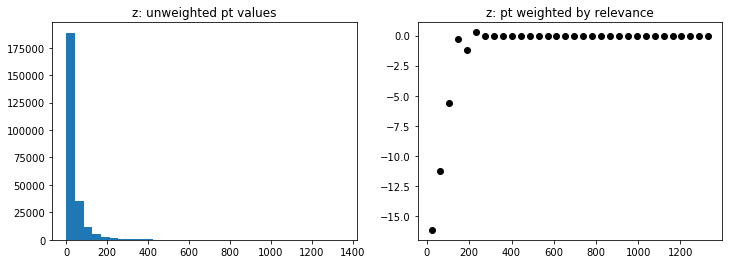

In [24]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(zvec[::4][:,:,0].flatten(), bins = 32)
plt.title("z: unweighted pt values")
plt.subplot(1,2,2)
plt.scatter(x_z[0], w_pt_z, c = '0', label = 'weighted by pt rel')
plt.title("z: pt weighted by relevance")
plt.show()

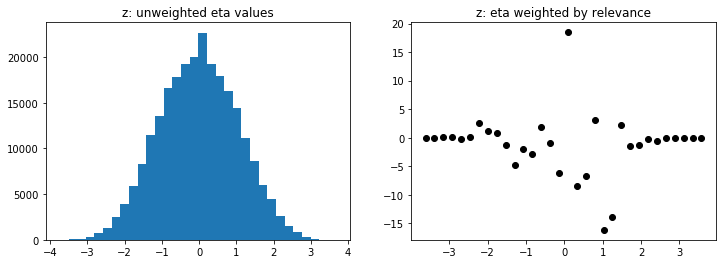

In [26]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(zvec[::4][:,:,1].flatten(), bins = 32)
plt.title("z: unweighted eta values")
plt.subplot(1,2,2)
plt.scatter(x_z[1], w_eta_z, c = '0', label = 'weighted by eta rel')
plt.title("z: eta weighted by relevance")
plt.show()

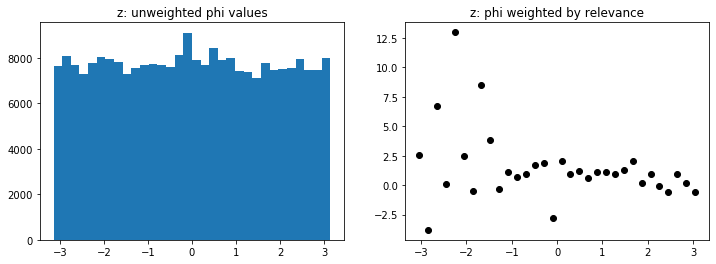

In [27]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(zvec[::4][:,:,2].flatten(), bins = 32)
plt.title("z: unweighted phi values")
plt.subplot(1,2,2)
plt.scatter(x_z[2], w_phi_z, c = '0', label = 'weighted by phi rel')
plt.title("z: phi weighted by relevance")
plt.show()

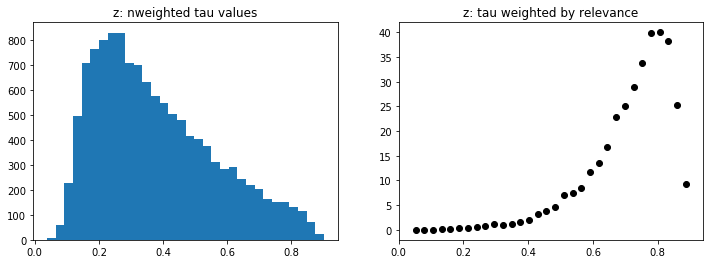

In [29]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(ztau[::4], bins = 32)
plt.title("z: nweighted tau values")
plt.subplot(1,2,2)
plt.scatter(x_z[3], w_tau_z, c = '0', label = 'weighted by tau rel')
plt.title("z: tau weighted by relevance")
plt.show()

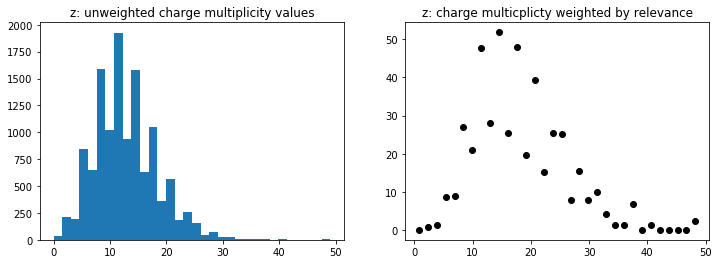

In [30]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(zmult[::4], bins = 32)
plt.title("z: unweighted charge multiplicity values")
plt.subplot(1,2,2)
plt.scatter(x_z[4], w_mult_z, c = '0', label = 'weighted by mult rel')
plt.title("z: charge multicplicty weighted by relevance")
plt.show()